# spark wordcount 1

In [28]:
from google.colab import files

uploaded = files.upload()

Saving pricing.csv to pricing.csv


In [29]:
!pip install pyspark

In [30]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.window import Window
from pyspark.sql.functions import udf, isnan, min, max, sum, count, desc, expr, avg
from pyspark.sql.types import IntegerType, LongType

from pyspark.ml.feature import StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GBTClassifier, LogisticRegressionModel, GBTClassificationModel, RandomForestClassificationModel

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd

In [42]:
from pyspark import SparkContext
# creating spark context
sc = SparkContext('local', 'Pricing App')

In [33]:
from pyspark.sql import functions as F
df = spark.read.csv('pricing.csv', header=True, inferSchema=True)
df.show()
df_clean = df.dropna(subset=["Price per Unit", "Quantity"])
df_clean = df_clean.withColumn("Price per Unit", df_clean["Price per Unit"].cast('float'))
df_clean = df_clean.withColumn("Quantity", df_clean["Quantity"].cast('int'))
category_analysis = df_clean.groupBy("Product Category").agg(
    avg("Price per Unit").alias("avg_price"),
    avg("Quantity").alias("avg_quantity")
)

category_analysis.show()

correlation = df_clean.stat.corr("Price per Unit", "Quantity")
print(f"Корреляция между ценой и количеством: {correlation}")

+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|Transaction ID|      Date|Customer ID|Gender|Age|Product Category|Quantity|Price per Unit|Total Amount|
+--------------+----------+-----------+------+---+----------------+--------+--------------+------------+
|             1|2023-11-24|    CUST001|  Male| 34|          Beauty|       3|            50|         150|
|             2|2023-02-27|    CUST002|Female| 26|        Clothing|       2|           500|        1000|
|             3|2023-01-13|    CUST003|  Male| 50|     Electronics|       1|            30|          30|
|             4|2023-05-21|    CUST004|  Male| 37|        Clothing|       1|           500|         500|
|             5|2023-05-06|    CUST005|  Male| 30|          Beauty|       2|            50|         100|
|             6|2023-04-25|    CUST006|Female| 45|          Beauty|       1|            30|          30|
|             7|2023-03-13|    CUST007|  Male| 46|     

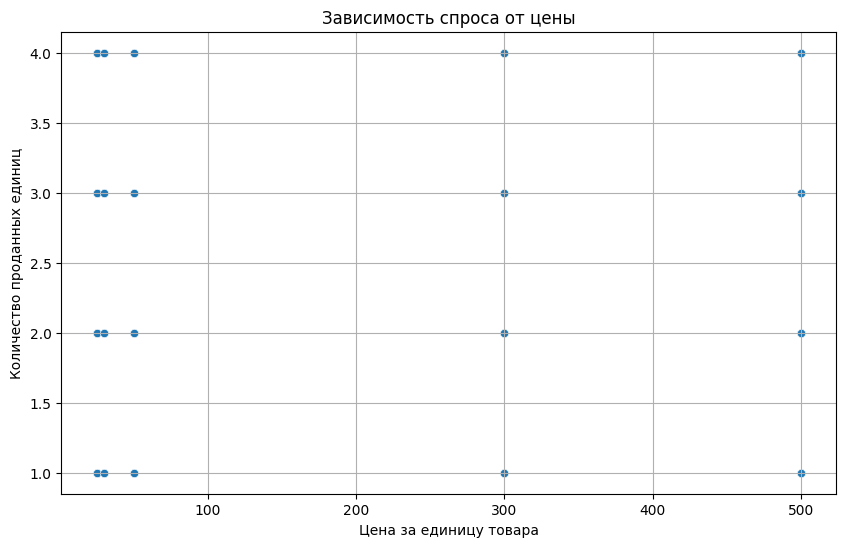

In [34]:
df_clean = df.dropna(subset=["Price per Unit", "Quantity"])

# Преобразуем данные в Pandas для удобства визуализации
df_pandas = df_clean.toPandas()

# Построение графика зависимости количества от цены
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Price per Unit", y="Quantity", data=df_pandas)

# Настройка графика
plt.title("Зависимость спроса от цены")
plt.xlabel("Цена за единицу товара")
plt.ylabel("Количество проданных единиц")
plt.grid(True)

# Показать график
plt.show()

# sparksql

In [ ]:
from google.colab import files

uploaded = files.upload()

In [35]:
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master('local') \
            .appName('SQL App').getOrCreate()
sc = spark.sparkContext

In [36]:
!cat pricing.csv

Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
5,2023-05-06,CUST005,Male,30,Beauty,2,50,100
6,2023-04-25,CUST006,Female,45,Beauty,1,30,30
7,2023-03-13,CUST007,Male,46,Clothing,2,25,50
8,2023-02-22,CUST008,Male,30,Electronics,4,25,100
9,2023-12-13,CUST009,Male,63,Electronics,2,300,600
10,2023-10-07,CUST010,Female,52,Clothing,4,50,200
11,2023-02-14,CUST011,Male,23,Clothing,2,50,100
12,2023-10-30,CUST012,Male,35,Beauty,3,25,75
13,2023-08-05,CUST013,Male,22,Electronics,3,500,1500
14,2023-01-17,CUST014,Male,64,Clothing,4,30,120
15,2023-01-16,CUST015,Female,42,Electronics,4,500,2000
16,2023-02-17,CUST016,Male,19,Clothing,3,500,1500
17,2023-04-22,CUST017,Female,27,Clothing,4,25,100
18,2023-04-30,CUST018,Female,47,Electronics,2,25,50
19,2023-09-16,CUST019

In [39]:
df = spark.read.csv('pricing.csv', header=True, inferSchema=True)
df.createOrReplaceTempView("sales_data")

query = """
    SELECT
        `Product Category`,
        MIN(`Price per Unit`) AS min_price,
        MAX(`Price per Unit`) AS max_price,
        AVG(`Price per Unit`) AS avg_price
    FROM sales_data
    GROUP BY `Product Category`
    ORDER BY `Product Category`
"""
result = spark.sql(query)
result.show()


+----------------+---------+---------+------------------+
|Product Category|min_price|max_price|         avg_price|
+----------------+---------+---------+------------------+
|          Beauty|       25|      500|184.05537459283389|
|        Clothing|       25|      500|174.28774928774928|
|     Electronics|       25|      500|181.90058479532163|
+----------------+---------+---------+------------------+

